# **Implications for Heat Stress in the Houston, Texas, United States Metropolitan Area**

This notebook performs analysis of heat stress across the Houston Metropolitan Area (HMA) from 2000-2020, utilitizing data from the National Land Cover Database (NLCD), Moderate Resolution Imaging Spectroradiometer (MODIS) Aqua and Terra satellites, and the Center for Disease Control's (CDC) Social Vulnerability Index (SVI).

## Import and Install Necessary Packages

In [1]:
!pip -q install statsmodels
!pip -q install rasterstats

#These imports are not necessary when using JupyterHub, as they are already included:
#!pip install geopandas
#!pip install rasterio

In [2]:
import geopandas as gpd
import pandas as pd
from rasterstats import zonal_stats
import rasterio
from rasterio.plot import show
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import json
import fiona
from osgeo import ogr
import numpy as np
from rasterio.features import geometry_mask
from matplotlib import axis
from matplotlib.colors import ListedColormap, BoundaryNorm

## **Comparing NLCD Classifications**

The NLCD land use-land cover (LULC) classifications can be useful in determining urban growth over a specific area through time. The following example uses this dataset to examine the urban growth of the HMA from 2001-2019. You can find the data here: https://www.mrlc.gov/data .

In [ ]:
# Define the standard NLCD color map using HEX code:
NLCD_COLORS = {
    11: '#486DA2',  # Open Water
    12: '#E7EFFC',  # Perennial Ice/Snow
    21: '#E1CDCE',  # Developed, Open Space
    22: '#DC9881',  # Developed, Low Intensity
    23: '#F10100',  # Developed, Medium Intensity
    24: '#AB0101',  # Developed, High Intensity
    31: '#B3AFA4',  # Barren Land (Rock/Sand/Clay)
    41: '#6BA966',  # Deciduous Forest
    42: '#1D6533',  # Evergreen Forest
    43: '#BDCC93',  # Mixed Forest
    51: '#B29C46',  # Dwarf Scrub
    52: '#D1BB82',  # Shrub/Scrub
    71: '#EDECCD',  # Grassland/Herbaceous
    72: '#D0D181',  # Sedge/Herbaceous
    73: '#A4CC51',  # Lichens
    74: '#82BA9D',  # Moss
    81: '#DDD83E',  # Pasture/Hay
    82: '#AE7229',  # Cultivated Crops
    90: '#BBD7ED',  # Woody Wetlands
    95: '#71A4C1',  # Emergent Herbaceous Wetlands
}

# Create a ListedColormap from the HEX:
nlcd_classes = sorted(NLCD_COLORS.keys())
nlcd_colors = [NLCD_COLORS[i] for i in nlcd_classes]
nlcd_cmap = ListedColormap(nlcd_colors)

In [ ]:
# Define labels for each numeric NLCD value:
nlcd_labels = {
    11: 'Open Water',
    12: 'Perennial Ice/Snow',
    21: 'Developed, Open Space',
    22: 'Developed, Low Intensity',
    23: 'Developed, Medium Intensity',
    24: 'Developed, High Intensity',
    31: 'Barren Land (Rock/Sand/Clay)',
    41: 'Deciduous Forest',
    42: 'Evergreen Forest',
    43: 'Mixed Forest',
    51: 'Dwarf Scrub',
    52: 'Shrub/Scrub',
    71: 'Grassland/Herbaceous',
    72: 'Sedge/Herbaceous',
    73: 'Lichens',
    74: 'Moss',
    81: 'Pasture/Hay',
    82: 'Cultivated Crops',
    90: 'Woody Wetlands',
    95: 'Emergent Herbaceous Wetlands',
}

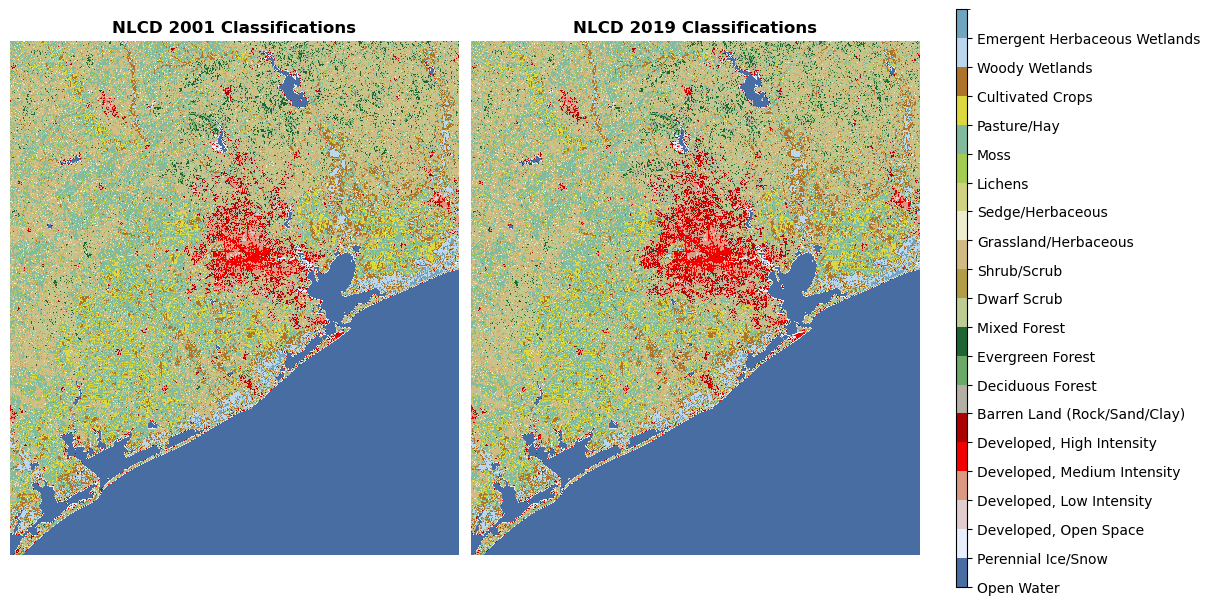

In [ ]:
# Read the first NLCD TIFF file (2001):
with rasterio.open('HMA-heat-stress/NLCD_2001.tif') as src1:
    data1 = src1.read(1)

# Read the second NLCD TIFF file (2019):
with rasterio.open('HMA-heat-stress/NLCD_2019.tif') as src2:
    data2 = src2.read(1)

### Plotting ###
# Create a figure with two subplots for side-by-side comparison:
fig, axs = plt.subplots(1, 2, figsize=(12, 6), constrained_layout=True)

# Define a BoundaryNorm for the colormap to correctly map the classifications to the correct colors:
norm = BoundaryNorm(sorted(list(NLCD_COLORS.keys()) + [max(NLCD_COLORS.keys()) + 1]), len(nlcd_colors))

# Plot the first NLCD TIFF in the first subplot:
nlcd_plot1 = axs[0].imshow(data1, cmap=nlcd_cmap, norm=norm)
axs[0].set_title('NLCD 2001 Classifications', fontweight='bold')
axs[0].axis('off')

# Plot the second NLCD TIFF in the second subplot:
nlcd_plot2 = axs[1].imshow(data2, cmap=nlcd_cmap, norm=norm)
axs[1].set_title('NLCD 2019 Classifications', fontweight='bold')
axs[1].axis('off')

# Add a colorbar with the appropriate labels to the image:
cbar = fig.colorbar(nlcd_plot1, ax=axs, orientation='vertical', fraction=0.02, pad=0.04, aspect=50)
cbar.set_ticks(sorted(NLCD_COLORS.keys()))
cbar.set_ticklabels([nlcd_labels[i] for i in sorted(NLCD_COLORS.keys())])

# Display the plot:
plt.show()

## **Examining Decadal Daytime LST**

The MODIS Terra and Aqua satellite archive contains Land Surface Temperature (LST) data from the past two decades for both the daytime and nighttime. The following example uses the daytime LST data to perform a decadal average analysis over the 2000-2009 and 2010-2019 periods in order to examine any changes that have occurred over the HMA. This data was pulled from https://modis.gsfc.nasa.gov/data/dataprod/mod11.php and pre-processed to remove cloud contamination.

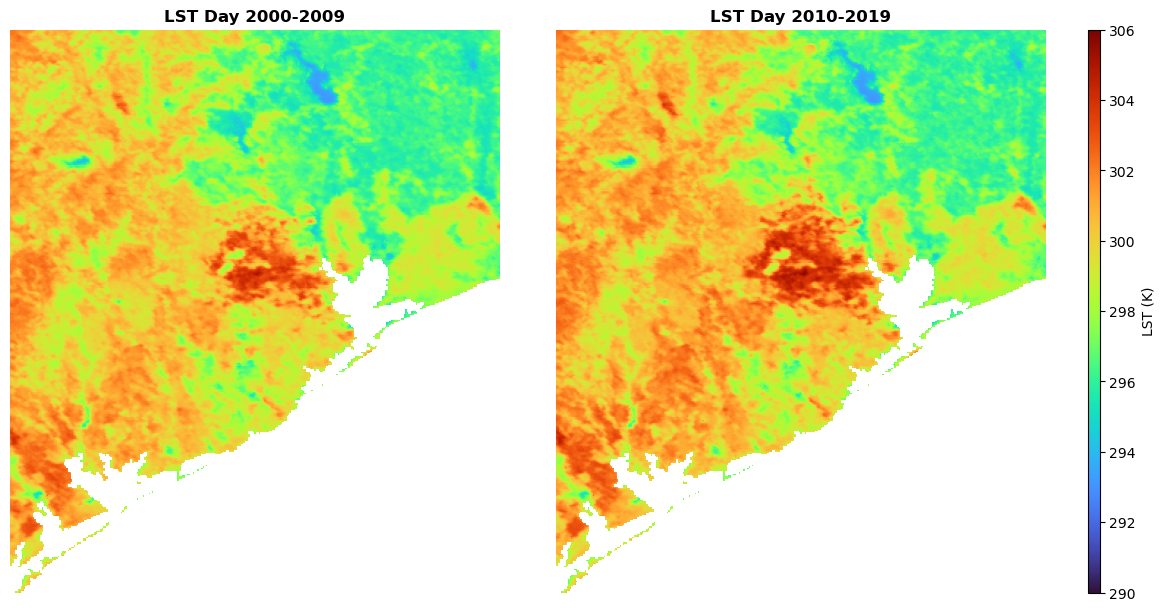

In [ ]:
# Read the first TIFF file:
with rasterio.open('HMA-heat-stress/LST_Day_2000-2009.tif') as src1:
    lst2000s = src1.read(1)

# Read the second TIFF file:
with rasterio.open('HMA-heat-stress/LST_Day_2010-2019.tif') as src2:
    lst2010s = src2.read(1)

### Plotting ###
# Create a figure with two subplots for easy comparison:
fig, axs = plt.subplots(1, 2, figsize=(12, 6), constrained_layout = True)

#Define scale factor (sf) for LST data (the appropriate sf can be found at the data download link):
sf = 0.02

# Plot the first TIFF in the first subplot:
lst_2000s = axs[0].imshow(lst2000s * sf, cmap='turbo', vmin = 290, vmax = 306)
axs[0].set_title('LST Day 2000-2009', fontweight = 'bold')
axs[0].axis('off')

# Plot the second TIFF in the second subplot:
lst_2010s = axs[1].imshow(lst2010s * sf, cmap='turbo', vmin = 290, vmax = 306)
axs[1].set_title('LST Day 2010-2019', fontweight = 'bold')
axs[1].axis('off')

# Add a colorbar to the figure:
cbar = fig.colorbar(lst_2000s, ax=axs, orientation='vertical', fraction=0.02, pad=0.04, aspect=50)
cbar.set_label('LST (K)')

# Display the plot:
plt.show()

## **Displaying Daytime LST Decadal Difference**

The following block of code takes the above decadal analysis and performs a difference calculation over the 2010s minus the 2000s in order to more effectively display the differences in daytime LST that have occurred across the HMA.

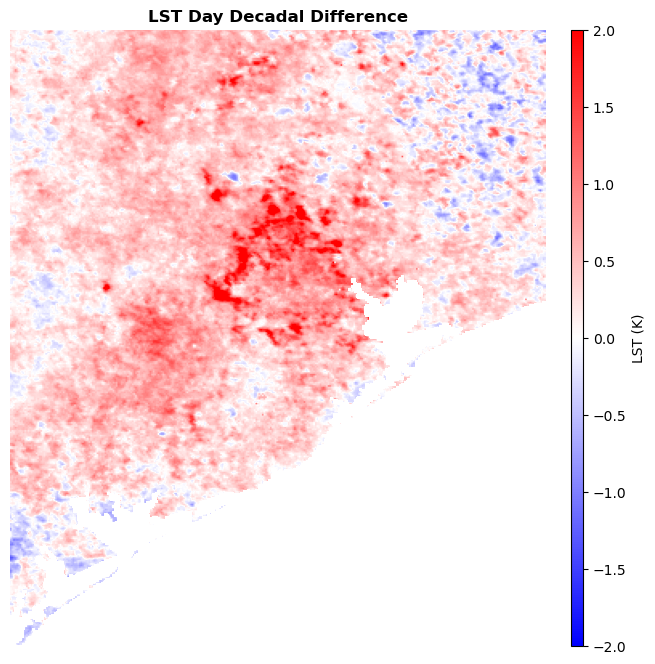

In [ ]:
#Compute the decadal difference:
lst_diff = (lst2010s * sf) - (lst2000s * sf)

### Plotting ###
#Create figure:
plt.figure(figsize=(8, 8))
plt.imshow(lst_diff, cmap = 'bwr', vmin = -2.0, vmax = 2.0)

# Add a colorbar to the figure:
plt.colorbar(label='LST (K)', orientation='vertical', fraction=0.02, pad=0.04, aspect=50)

# Add labels and title:
plt.title('LST Day Decadal Difference', fontweight = 'bold')
plt.axis('off')

# Display the plot:
plt.show()

## **Examining Decadal NDVI**

As was done for the daytime LST, the same will be done for the Normalized Difference Vegetation Index (NDVI), which can give an indication of green space and vegetation health. The NDVI data archive can be accessed at this link: https://modis.gsfc.nasa.gov/data/dataprod/mod13.php .

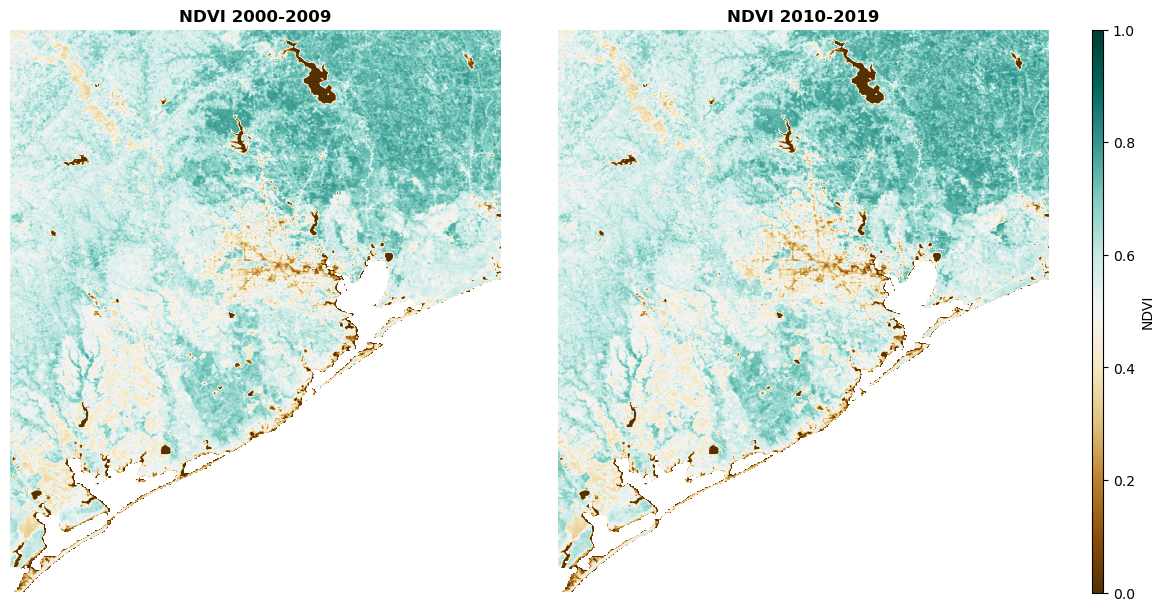

In [ ]:
# Read the first TIFF file:
with rasterio.open('HMA-heat-stress/NDVI_2000-2009.tif') as src1:
    ndvi2000s = src1.read(1)

# Read the second TIFF file:
with rasterio.open('HMA-heat-stress/NDVI_2010-2019.tif') as src2:
    ndvi2010s = src2.read(1)

### Plotting ###
# Create a figure with two subplots for easy comparison:
fig, axs = plt.subplots(1, 2, figsize=(12, 6), constrained_layout = True)

#Define scale factor for NDVI data:
sf = 0.0001

# Plot the first TIFF in the first subplot:
ndvi_2000s = axs[0].imshow(ndvi2000s * sf, cmap='BrBG', vmin = 0.0, vmax = 1.0)
axs[0].set_title('NDVI 2000-2009', fontweight = 'bold')
axs[0].axis('off')

# Plot the second TIFF in the second subplot:
ndvi_2010s = axs[1].imshow(ndvi2010s * sf, cmap='BrBG', vmin = 0.0, vmax = 1.0)
axs[1].set_title('NDVI 2010-2019', fontweight = 'bold')
axs[1].axis('off')

# Add a colorbar to the figure:
cbar = fig.colorbar(ndvi_2000s, ax=axs, orientation='vertical', fraction=0.02, pad=0.04, aspect=50)
cbar.set_label('NDVI')

# Display the plot:
plt.show()

## **Displaying NDVI Decadal Difference**

The following block of code takes the above decadal analysis and performs a difference calculation over the 2010s minus the 2000s in order to more effectively display the differences in NDVI that have occurred across the HMA.

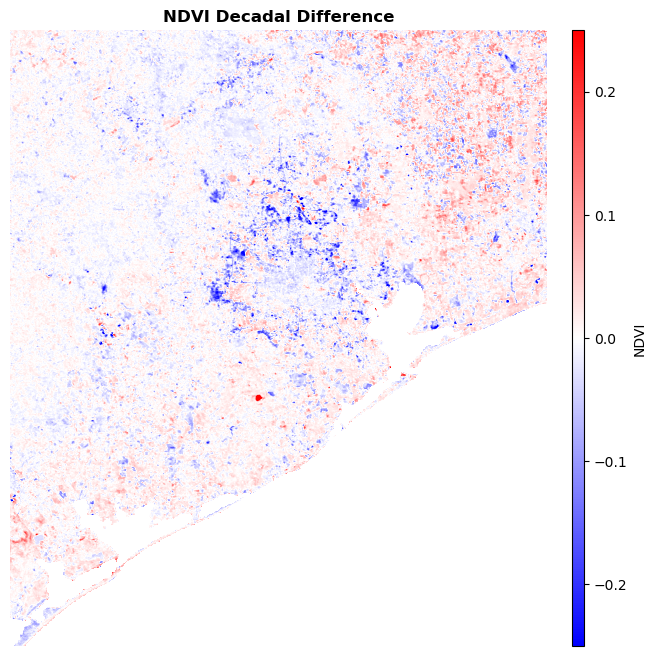

In [ ]:
#Compute the decadal difference:
ndvi_diff = (ndvi2010s * sf) - (ndvi2000s * sf)

### Plotting ###
#Create figure:
plt.figure(figsize=(8, 8))
plt.imshow(ndvi_diff, cmap = 'bwr', vmin = -0.25, vmax = 0.25)

# Add a colorbar to the figure:
plt.colorbar(label='NDVI', orientation='vertical', fraction=0.02, pad=0.04, aspect=50)

# Add labels and title:
plt.title('NDVI Decadal Difference', fontweight = 'bold')
plt.axis('off')

# Display the plot:
plt.show()

## **Social Vulnerability Index (SVI) Mapping**

The SVI is a comprehensive dataset that examines 16 socioeconomic variables in four main categories (poverty/income, household, racial, and transportation demographics). This dataset is provided by the CDC at this link: https://www.atsdr.cdc.gov/placeandhealth/svi/data_documentation_download.html . The following example will plot the 2020 total SVI classification, which is a combination of all variables that represents how socioeconomically disadvantaged a census tract is compared to the national average (1 = higher disparity, 0 = lower disparity). The following analysis is performed over the HMA Census Designated Area (CDA).

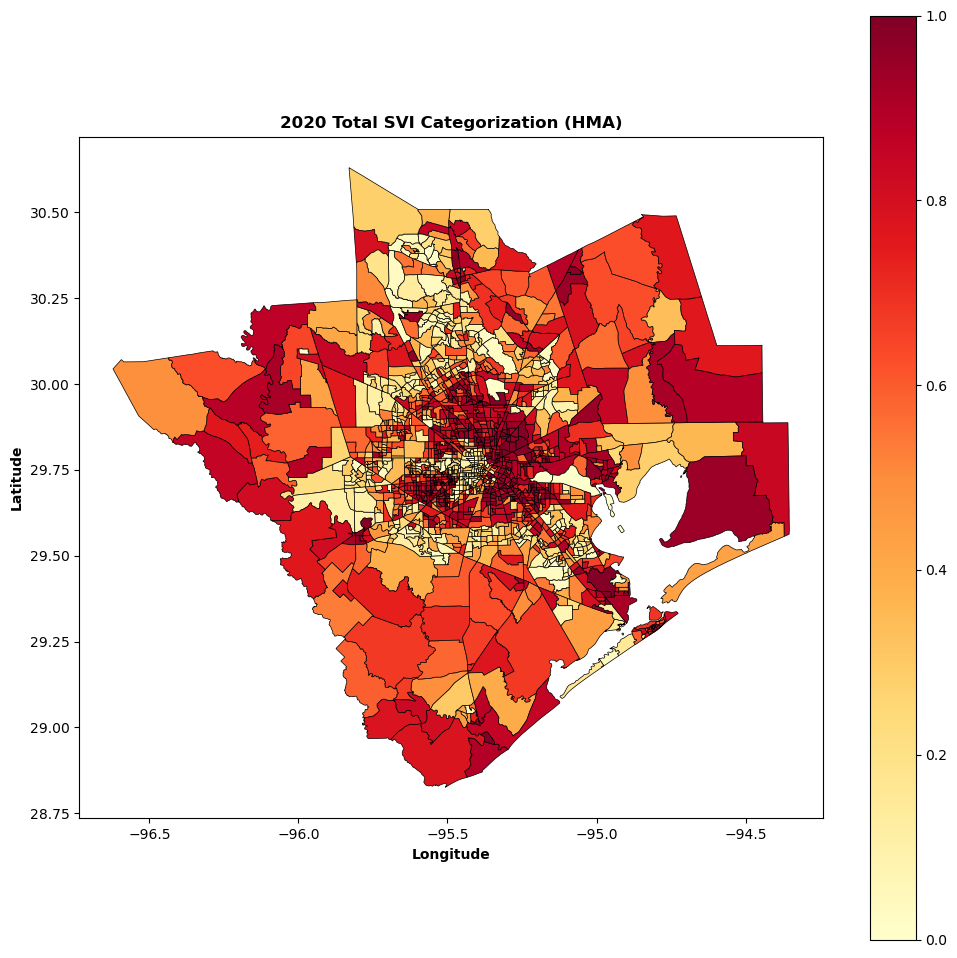

In [7]:
#Read in the SVI shapefile:
svishp = gpd.read_file("SVI2020/SVI_2020HMA.shp")

### Plotting ###
# Plot the shapefile:
fig, ax = plt.subplots(figsize=(12,12))
svishp.plot(ax=ax, edgecolor='black', column='RPL_THEMES', cmap='YlOrRd', legend=True ,vmin=0, vmax=1, lw = 0.5)

# Add title and labels:
ax.set_title("2020 Total SVI Categorization (HMA)", fontweight='bold')
ax.set_xlabel("Longitude", fontweight='bold')
ax.set_ylabel("Latitude", fontweight='bold')

# Show the plot:
plt.show()

# **Examining Average Daytime LST and NDVI by SVI Bin**

The final analysis to be performed in this notebook examining heat stress in the HMA is to examine the average daytime LST and NDVI across Harris County, Texas (where the city of Houston is located) for 2020 and break the values out by SVI bins. The example below uses the percentage of a census tract's population that falls under the 150% poverty line, which is one of the 16 variables used to compute the total SVI classification in the above plot.

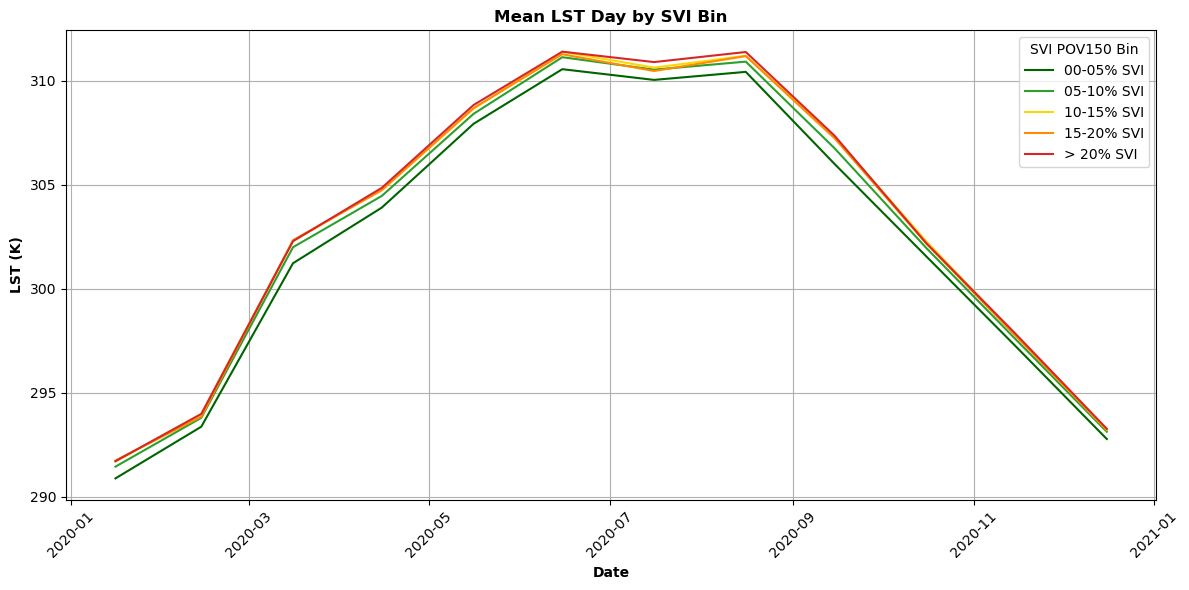

In [ ]:
# Read in the CSV file. This file was created by extracting the mean value of the monthly averaged LST Day and NDVI tifs over the census tracts that fall into the five defined SVI bins:
df = pd.read_csv('HMA-heat-stress/HarrisTX_2020_LST_NDVI_by_SVI_Bin.csv')

# Convert the 'Date' column to datetime:
df['Date'] = pd.to_datetime(df['Date'])

# Define custom color palette for plotting the time series:
custom_palette = ['darkgreen', 'tab:green', 'gold', 'darkorange', 'tab:red']

# Group by SVI column:
grouped = df.groupby('SVI_POV150')

# Subtract one month from each date, as these are monthly average values and the Date column is listed as the last day of the month. This line will 'center' the value on the month in the time series:
df['Date'] = df['Date'] - pd.DateOffset(days = 15)

### Plotting LST Day ###
# Plot the data for each SVI group with custom colors:
plt.figure(figsize=(12, 6))

for i, (name, group) in enumerate(grouped):
    plt.plot(group['Date'], group['LST'], label=name, color=custom_palette[i])

# Add titles and labels:
plt.title('Mean LST Day by SVI Bin', fontweight = 'bold')
plt.xlabel('Date', fontweight = 'bold')
plt.ylabel('LST (K)', fontweight = 'bold')

#Add a legend and format ticks and grids:
plt.legend(title='SVI POV150 Bin')
plt.xticks(rotation=45)
plt.grid()

# Display the plot:
plt.tight_layout()
plt.show()

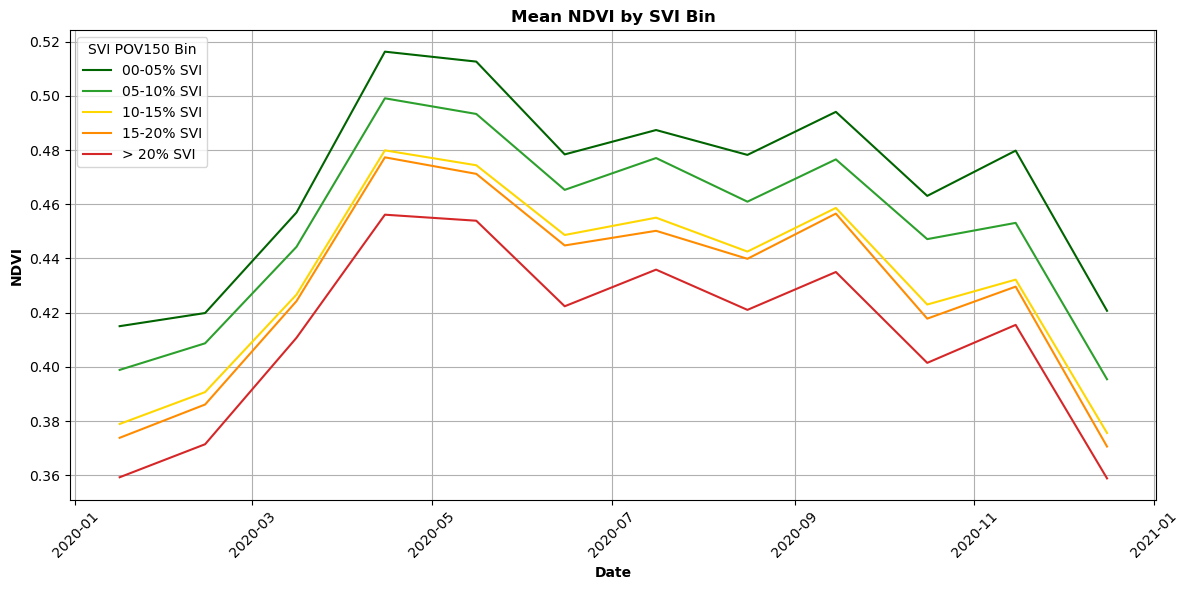

In [ ]:
### Plotting NDVI ###
# Plot the data for each SVI group with custom colors
plt.figure(figsize=(12, 6))

for i, (name, group) in enumerate(grouped):
    plt.plot(group['Date'], group['NDVI'], label=name, color=custom_palette[i])

# Add titles and labels:
plt.title('Mean NDVI by SVI Bin', fontweight = 'bold')
plt.xlabel('Date', fontweight = 'bold')
plt.ylabel('NDVI', fontweight = 'bold')

#Add a legend and format ticks and grids:
plt.legend(title='SVI POV150 Bin')
plt.xticks(rotation=45)
plt.grid()

# Display the plot:
plt.tight_layout()
plt.show()

## **Summary**

This notebook walks through how to perform analysis of heat stress in a major metropolitan area such as the HMA. The analysis utilized NLCD, MODIS, and SVI datasets, which are all publicly available so that this analysis can be replicated for other areas of interest.